# **GROUP PROJECT**

https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-74759-0_345

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict
import geopandas as gpd
import random
from deap import base, creator, tools
import pyproj
from shapely.geometry import Point, LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ortools as ort
import datetime as dt
# pysal submodule imports
from pysal.lib import cg, examples
from pysal.explore import spaghetti as spgh

import geopandas as gpd
from shapely.geometry import Point
from ortools.linear_solver import pywraplp
import copy, sys, warnings
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
except ImportError:
    pass

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from ortools.sat.python import cp_model

C:\Users\Noah\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# **1. Problem Variables**

In [2]:
# truck variables
truckRange = 10
truckCapacity = 500
nCities = 20
M = 20

# **2. SET UP CITIES**

In [3]:
def buildCityDF(nCities,gridX=100,gridY=100):
    xs = np.random.randint(0,gridX,nCities)
    ys = np.random.randint(0,gridY,nCities)
    pts = [Point(xs[i],ys[i]) for i in range(0,nCities)]
    demands = np.random.randint(0,101,nCities)
    facilityOneCosts = np.random.randint(0,101,nCities)
    facilityTwoCosts = np.random.randint(100,201,nCities)
    cityIndices = range(0,nCities)
    cities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts})
    return cities

In [4]:
def buildDistanceMatrix_Euclidean(cities):
    distances = np.zeros((len(cities),len(cities)))
    for i,row in cities.iterrows():
        for j,row2 in cities.iterrows():
            distances[j,i] = row.geometry.distance(row2.geometry)
    return distances

In [11]:
def assignFacilitiesAndCluster(cities,M = 100,Rvz=[100000,200000],truckCapacityZ = [40000,80000],alpha=75.0,truckCapacity = 80000,fractionTruckRangeAllowed=0.8,nFacility=1):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
#     solver_instance = cp_model.CpModel()
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()
    zRange = len(Rvz)
    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)


#     model.parameters.max_time_in_seconds = 60.0 * 5

    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(zRange)} # charging station location decision/ concentrator
    
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(zRange)]
#     obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(zRange)]

    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == nFacility)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= model.Sum([truckCapacityZ[z]*yjz[j,z] for z in range(zRange)]))
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(zRange)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(zRange)]) <= M)
        
    # Total tour length constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= model.Sum([yjz[j,z]*Rvz[z]*fractionTruckRangeAllowed for z in range(zRange)]))
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(zRange)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

# **3. SOLVE TSP SUB-TOURS**

In [12]:
def convertTourToPathDF(tour,resultGDF):
#     tour = list(resultGDF[resultGDF["assignment"]==tour]["City Index"])
    tour.append(tour[0]) # Return to end
    startNodes = []
    endNodes = []
    startCoords = []
    endCoords = []
    lines = [] # https://gis.stackexchange.com/questions/95670/how-to-create-a-shapely-linestring-from-two-points
    for i in range(0,len(tour)):
        currentCity = tour[i]
        if i < len(tour)-1:
            nextCity = tour[i+1]
        else:
            nextCity = tour[0]
        startNodes.append(currentCity)
        endNodes.append(nextCity)
        startPoint = resultGDF[resultGDF["City Index"]==currentCity].geometry
        startCoords.append(startPoint)
        endPoint = resultGDF[resultGDF["City Index"]==nextCity].geometry
        endCoords.append(endPoint)
        line = LineString([(startPoint.x,startPoint.y),(endPoint.x,endPoint.y)])
        lines.append(line)
    gdf = gpd.GeoDataFrame({"Start Node":startNodes,"End Node":endNodes,"geometry":lines})
    return gdf

In [13]:
# https://developers.google.com/optimization/routing/tsp
"""Simple travelling salesman problem between cities."""

def create_data_model(dfSubset):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = buildDistanceMatrix_Euclidean(dfSubset.reset_index())
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, assignment,dfSubset):
    """Prints assignment on console."""
    optimizedRoute = []
#     print(f"Objective: ")
#     print('Objective: {} meters'.format(assignment.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    orderedDFSubset = dfSubset.reset_index()
    while not routing.IsEnd(index):
        correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
        optimizedRoute.append(correctedCityIndex)
#         print(f"******{correctedCityIndex}")
#         print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
#         plan_output += ' {} ->'.format(manager.IndexToNode(index))
        plan_output += ' {} ->'.format(correctedCityIndex)

        previous_index = index
        index = assignment.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
#     plan_output += ' {}\n'.format(manager.IndexToNode(index))
    correctedCityIndex = orderedDFSubset.iloc[manager.IndexToNode(index)][0]
    plan_output += ' {}\n'.format(correctedCityIndex)
#     print(f"******{correctedCityIndex}")
    optimizedRoute.append(correctedCityIndex)
#     print(f"====>{orderedDFSubset.iloc[manager.IndexToNode(index)]}")
    plan_output += f'Route distance: {route_distance/1000.0} km\n'
    print(plan_output)
    return optimizedRoute,route_distance


def main(dfSubset):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(dfSubset)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        route,route_distance = print_solution(manager, routing, assignment,dfSubset)
    return route,route_distance

In [14]:
illinoisCitiesPath = "Final Presentation\\tl_2016_17_place\\tl_2016_17_place.shp"
illinoisCitiesPath = "Final Presentation\\illinois_projected.shp"
illinois = gpd.read_file(illinoisCitiesPath)

In [15]:
nCities = 10
facilityOneBaseCost = 100000
facilityOneBaseSTD = 10000
facilityTwoBaseCost = 1000000
facilityTwoBaseSTD = 100000
baseDemand = 10000
baseDemandSTD = 10000
demands = np.random.normal(baseDemand, baseDemandSTD, nCities)
demands = [np.abs(demand) for demand in demands]
facilityOneCosts = np.random.normal(facilityOneBaseCost, facilityOneBaseSTD, nCities)
facilityOneCosts = [np.abs(facilityOneCost) for facilityOneCost in facilityOneCosts]
facilityTwoCosts = np.random.normal(facilityTwoBaseCost, facilityTwoBaseSTD, nCities)
facilityTwoCosts = [np.abs(facilityTwoCost) for facilityTwoCost in facilityTwoCosts]
cityIndices = range(nCities)
xs = []
ys = []
pts = []
polygons = []
cityNames = []
illinoisGeoms = illinois.sort_values("ALAND",ascending=False).reset_index()
for i,row in illinoisGeoms[0:nCities].iterrows():
    pts.append(row["geometry"].centroid)
    polygons.append(row["geometry"])
    xs.append(row["geometry"].centroid.x)
    ys.append(row["geometry"].centroid.y)
    cityNames.append(row["NAME"])


illinoisCities = gpd.GeoDataFrame({"x":xs,"y":ys,"demand":demands,"geometry":pts,"polygon":polygons,"City Index":cityIndices,"Facility One Cost":facilityOneCosts,"Facility Two Cost":facilityTwoCosts,"Name":cityNames})

In [27]:
model,yjz,xij,resultGDF,status = assignFacilitiesAndCluster(illinoisCities,M=20,Rvz=[100000,200000],alpha=10,fractionTruckRangeAllowed=0.5)

Optimal Solution Found


In [16]:
# n = 2 facilities for redundancy model
assignments = np.zeros((nCities,nCities))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
cluster2 = []
for cityNodeID in range(nCities):
    counter = 0

    for rootNodeID in range(nCities):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            if counter == 0:
                cluster.append(rootNodeID)
                counter += 1
            else:
                cluster2.append(rootNodeID)
        
resultGDF["assignment"] = cluster
resultGDF["assignment2"] = cluster2
uniqueClusters = list(set(cluster))


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()

illinois.plot(ax=ax1,color="blue",alpha=0.1)
illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].plot(ax=ax1,color="red",alpha=0.2)
# illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax1,color="white",marker='*')

colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    if resultGDF.iloc[uniqueClusters[i]]["Status: Facility Type 0"]==1:
        facilityType = 0
        vehicleType = "Standard range"
    else:
        facilityType = 1
        vehicleType = "Extended range"
    label = f"({resultGDF.iloc[uniqueClusters[i]].x:,.0f},{resultGDF.iloc[uniqueClusters[i]].y:,.0f}): {tourLength/1000:,.0f} KM, Vehicle Type {facilityType}"
    label = f"{resultGDF.iloc[uniqueClusters[i]].Name}: {tourLength/1000:,.0f} KM, {vehicleType} vehicle"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
    # plot the tour
    ls = "dashed"
    if facilityType == 1:
        ls = "dotted"
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls=ls,alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

NameError: name 'xij' is not defined

Route for vehicle 0:
 0 -> 1 -> 8 -> 0
Route distance: 227.235 km

Route for vehicle 0:
 3 -> 9 -> 3
Route distance: 265.522 km

Route for vehicle 0:
 4 -> 6 -> 4
Route distance: 302.488 km

Route for vehicle 0:
 2 -> 5 -> 7 -> 2
Route distance: 253.825 km



Text(721.4, 0.5, 'City')

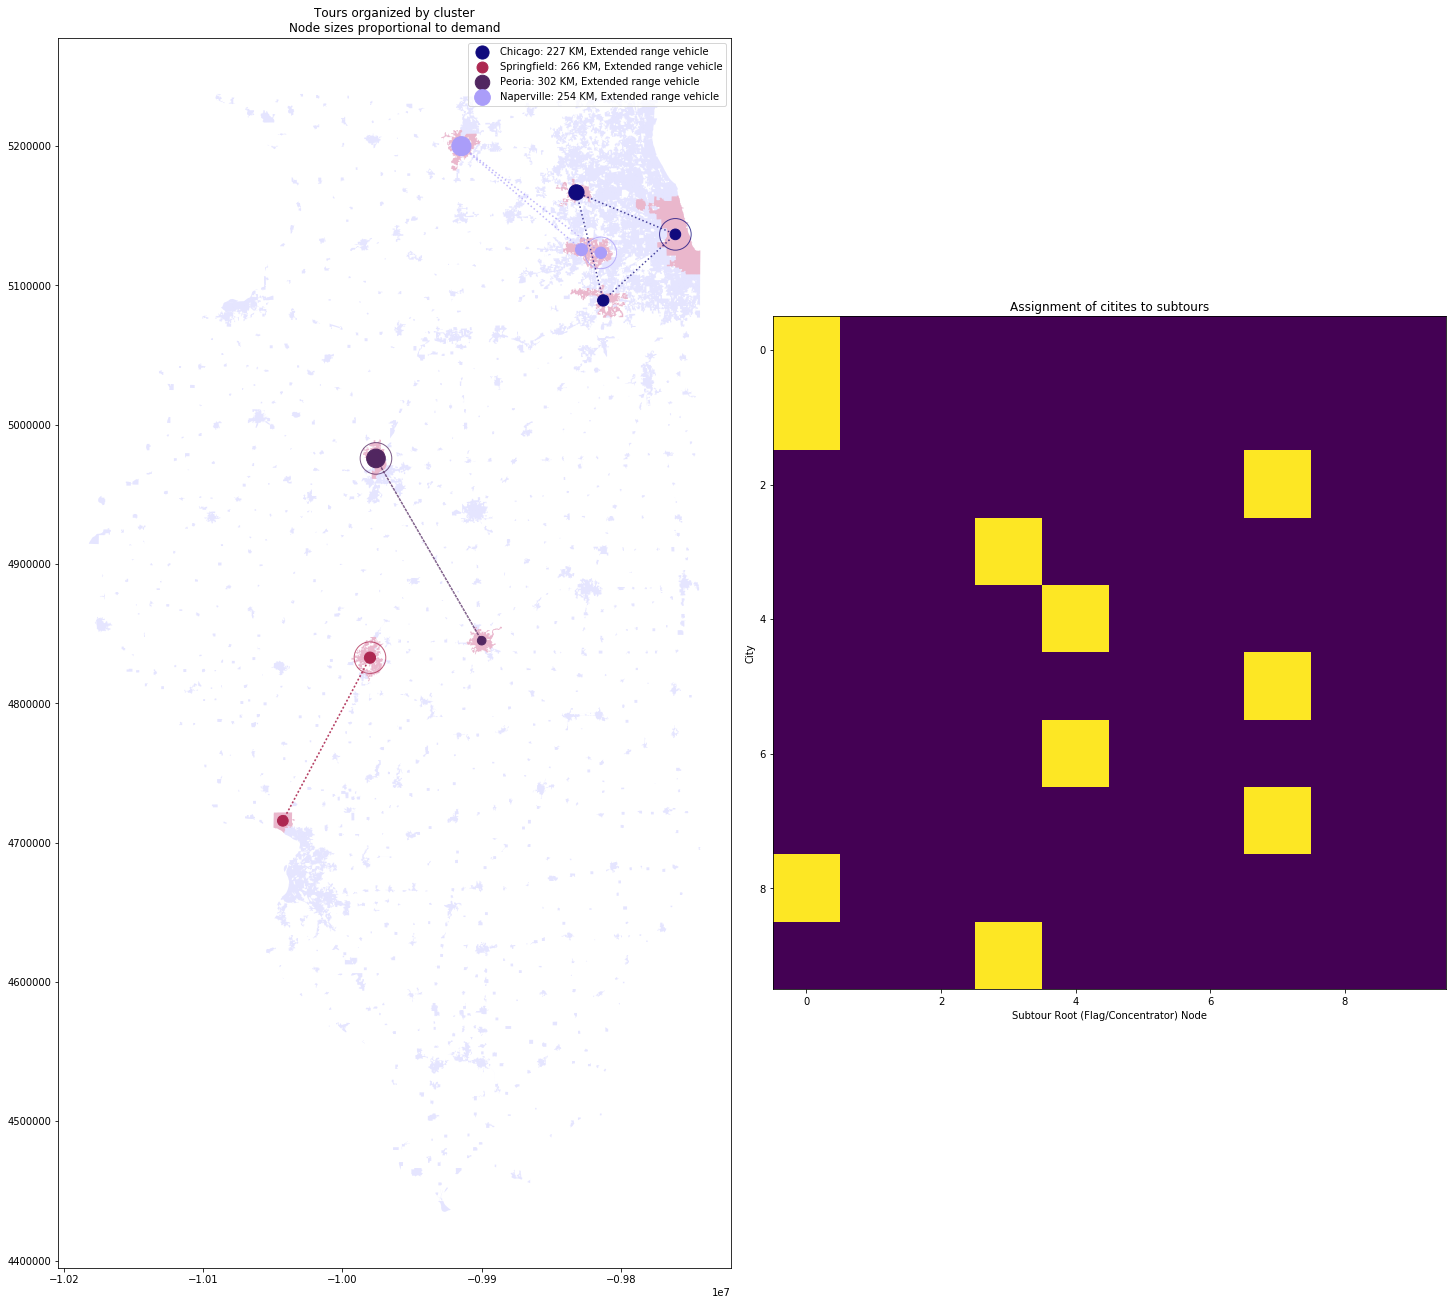

In [23]:
assignments = np.zeros((nCities,nCities))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(nCities):
    for rootNodeID in range(nCities):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()

illinois.plot(ax=ax1,color="blue",alpha=0.1)
illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].plot(ax=ax1,color="red",alpha=0.2)
# illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax1,color="white",marker='*')

colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    if resultGDF.iloc[uniqueClusters[i]]["Status: Facility Type 0"]==1:
        facilityType = 0
        vehicleType = "Standard range"
    else:
        facilityType = 1
        vehicleType = "Extended range"
    label = f"({resultGDF.iloc[uniqueClusters[i]].x:,.0f},{resultGDF.iloc[uniqueClusters[i]].y:,.0f}): {tourLength/1000:,.0f} KM, Vehicle Type {facilityType}"
    label = f"{resultGDF.iloc[uniqueClusters[i]].Name}: {tourLength/1000:,.0f} KM, {vehicleType} vehicle"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
    # plot the tour
    ls = "dashed"
    if facilityType == 1:
        ls = "dotted"
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls=ls,alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

In [ ]:
buildDistanceMatrix_Euclidean(resultGDF)

In [10]:
model,yjz,xij,resultGDF,status = assignFacilitiesAndCluster(illinoisCities,M=20,Rvz=[200000,400000],truckCapacityZ = [40000,80000],alpha=0.001,fractionTruckRangeAllowed=0.75)

TypeError: in method 'new_Solver', argument 2 of type 'operations_research::MPSolver::OptimizationProblemType'

In [17]:
alpha = 0.1
assignments = np.zeros((nCities,nCities))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(nCities):
    for rootNodeID in range(nCities):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()

illinois.plot(ax=ax1,color="blue",alpha=0.1)
illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].plot(ax=ax1,color="red",alpha=0.2)
# illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax1,color="white",marker='*')

colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
totalCost = 0.0
subtourRoutingCosts = {}
subtourConstructionCosts = {}
totalConstructionCost = np.sum(resultGDF["Facility One Cost"] * resultGDF["Status: Facility Type 0"] + resultGDF["Facility Two Cost"] * resultGDF["Status: Facility Type 1"])
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    if resultGDF.iloc[uniqueClusters[i]]["Status: Facility Type 0"]==1:
        facilityType = 0
        vehicleType = "Standard range"
    else:
        facilityType = 1
        vehicleType = "Extended range"
    subtourRoutingCosts[i] = alpha * tourLength
    label = f"({resultGDF.iloc[uniqueClusters[i]].x:,.0f},{resultGDF.iloc[uniqueClusters[i]].y:,.0f}): {tourLength/1000:,.0f} KM, Vehicle Type {facilityType}"
    label = f"{resultGDF.iloc[uniqueClusters[i]].Name}: {tourLength/1000:,.0f} KM, {vehicleType} vehicle"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
    # plot the tour
    ls = "dashed"
    if facilityType == 1:
        ls = "dotted"
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls=ls,alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

NameError: name 'xij' is not defined

In [79]:
resultGDF

,x,y,demand,geometry,polygon,City Index,Facility One Cost,Facility Two Cost,Name,Status: Facility Type 0,Status: Facility Type 1,assignment
0,-9.761033e+06,5.136620e+06,3265.924603,POINT (-9761032.643654963 5136619.851659001),POLYGON ((-9789447.915200001 5161119.332400002...,0,88127.193970,1.168493e+06,Chicago,0.0,0.0,18
1,-9.812818e+06,5.089202e+06,9007.498879,POINT (-9812817.852492342 5089202.112337102),(POLYGON ((-9836391.464600001 5094605.00670000...,1,96727.594043,9.744342e+05,Joliet,0.0,0.0,14
2,-9.914625e+06,5.199910e+06,3471.362072,POINT (-9914624.606907682 5199910.159028099),(POLYGON ((-9901115.537900001 5202313.51709999...,2,94323.041740,1.079202e+06,Rockford,0.0,0.0,37
3,-9.980241e+06,4.832799e+06,12397.114883,POINT (-9980240.949010463 4832798.992934125),(POLYGON ((-9990763.348999999 4836718.88620000...,3,94867.770928,1.286276e+06,Springfield,1.0,0.0,3
4,-9.975938e+06,4.975814e+06,5738.940123,POINT (-9975937.664920764 4975813.53921454),POLYGON ((-9985214.414999999 4979468.273800001...,4,94173.914467,1.053057e+06,Peoria,1.0,0.0,4
5,-9.828415e+06,5.125664e+06,5144.608795,POINT (-9828414.878063975 5125664.28168854),"(POLYGON ((-9819460.5472 5132383.862199999, -9...",5,105557.091362,8.187493e+05,Aurora,1.0,0.0,5
6,-9.900056e+06,4.844982e+06,5527.180883,POINT (-9900056.07244744 4844982.389529885),"(POLYGON ((-9895022.2151 4846048.145900004, -9...",6,96716.287247,1.045392e+06,Decatur,1.0,0.0,6
7,-9.814553e+06,5.123351e+06,5506.256770,POINT (-9814553.103840169 5123350.544294744),(POLYGON ((-9811223.013599999 5130011.47640000...,7,80582.195107,9.418186e+05,Naperville,0.0,0.0,5
8,-9.832036e+06,5.166747e+06,3594.829580,POINT (-9832035.636831645 5166746.83408088),"(POLYGON ((-9822604.1018 5166697.169200003, -9...",8,81149.514696,1.017225e+06,Elgin,0.0,0.0,25
9,-1.004278e+07,4.715692e+06,14660.600473,POINT (-10042782.08002698 4715691.713624574),"POLYGON ((-10049480.2696 4711757.696000002, -1...",9,92434.067988,1.063726e+06,Godfrey,1.0,0.0,9


In [66]:
totalConstructionCost

6432606.788856618

In [67]:
totalRoutingCost = np.sum(list(subtourRoutingCosts.values()))

In [68]:
f"${totalConstructionCost + totalRoutingCost:,.2f}"

'$8,335,136.79'

# **CLEAN UP, CLEAN UP, EVERYBODY EVERYWHERE.  CLEAN UP, CLEAN UP, EVERYBODY DO YOUR SHARE**

TODO
- Try rewriting to use CPSAT with multithreading
- Clean up code
- Come up with real values for demand and costs

In [12]:
cities = buildCityDF(nCities)

In [132]:
def assignFacilitiesAndCluster(cities,M = 100,Rv=100,alpha=75.0,truckCapacity = 80000):
    solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
    distances = buildDistanceMatrix_Euclidean(cities)
    cij = distances
    n_customers = cij.shape[0]
    range_customers = range(n_customers)
    n_facilityCandidates = cij.shape[1]
    range_facilityCandidates = range(n_facilityCandidates)
    demands = np.array(cities["demand"])
    demands_sum = demands.sum()
    fiz = facilityCost = cities[["Facility One Cost","Facility Two Cost"]].as_matrix()

    model = pywraplp.Solver("Capacitated Fixed Charge", solver_instance)
    
    xij = {(i,j): model.IntVar(0,1, 'x[%i,%i]' % (i,j)) for i in range_customers for j in range_facilityCandidates} # which facility is served by which 
    yjz = {(j,z): model.IntVar(0,1, 'y[%i,%i]' % (j,z)) for j in range_facilityCandidates for z in range(2)} # charging station location decision/ concentrator
    
    obj = [alpha * (cij[0,j]+cij[i,j]+cij[i,0]) * xij[i,j] + alpha*2*cij[0,j]*yjz[j,z] + fiz[i,z] * yjz[j,z] for i in range_customers for j in range_facilityCandidates for z in range(2)]
    
    # Service Constraint
    for i in range_customers:
        model.Add(model.Sum([xij[i,j] for j in range_facilityCandidates]) == 1)
    
    # Capacity Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([demands[i] * xij[i,j] for i in range_facilityCandidates]) <= truckCapacity)
    
    # Assignment Constraint
    for i in range_customers:
        for j in range_facilityCandidates:
            model.Add(xij[i,j] <= model.Sum([yjz[j,z] for z in range(2)]))
    
    # Maximum Concentratorrs Constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for j in range_facilityCandidates for z in range(2)]) <= M)
        
    # Total tour length constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([xij[i,j]*cij[i,j] for i in range_facilityCandidates]) <= Rv)
        
    # Z limitation constraint
    for j in range_facilityCandidates:
        model.Add(model.Sum([yjz[j,z] for z in range(2)]) <= 1)

    model.Minimize(model.Sum(obj))
    status = model.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal Solution Found')

    resultGDF = cities.copy(deep=True)
    for z in range(2):
        resultGDF[f"Status: Facility Type {z}"] = [yjz[j,z].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 0"] = [yjz[j,0].solution_value() for j in range_facilityCandidates]
#     resultGDF["Status: Facility Type 1"] = [yjz[j,1].solution_value() for j in range_facilityCandidates]
    return model,yjz,xij,resultGDF,status

In [14]:
model,yjz,xij,resultGDF,status = assignFacilitiesAndCluster(cities,M=30,Rv=100,alpha=0.001)

Optimal Solution Found


Text(721.4, 0.5, 'City')

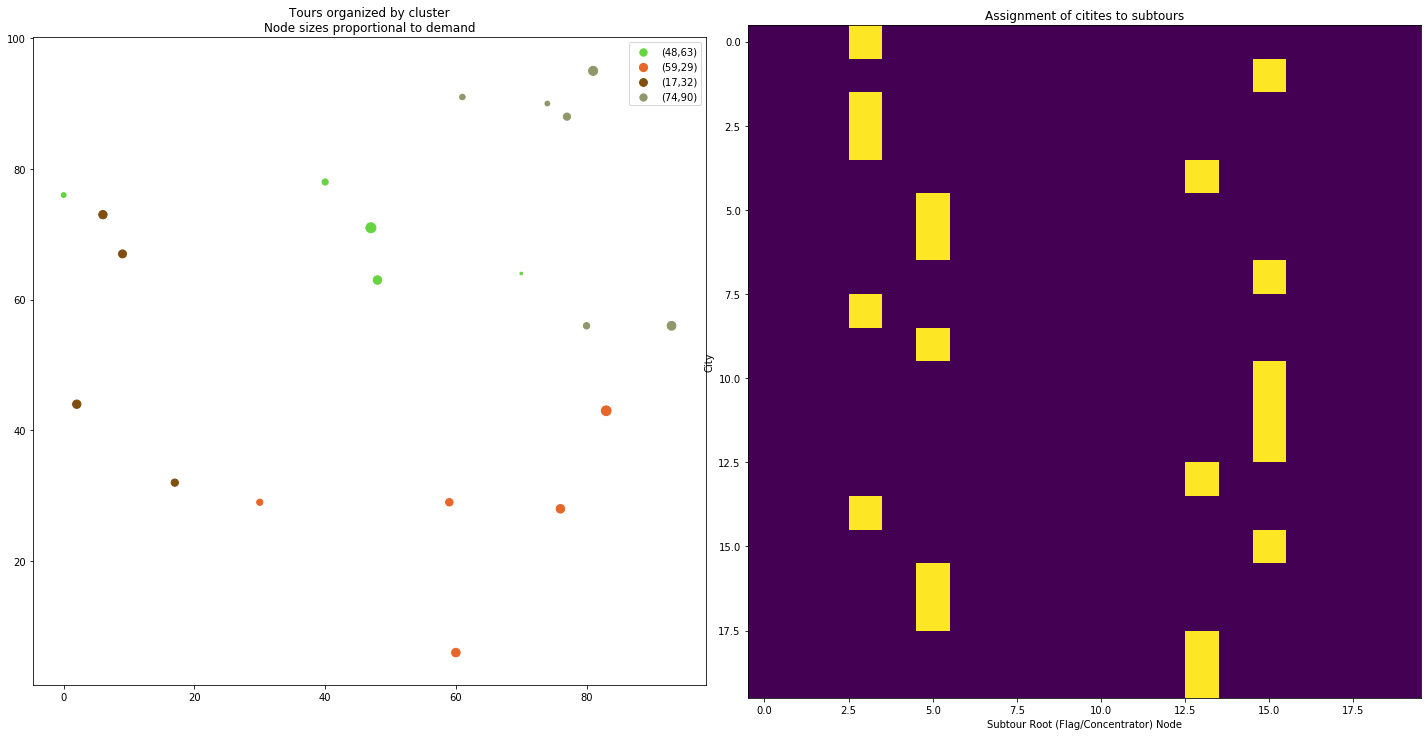

In [15]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"],label=f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y})")
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

In [4]:
cities_illinois = illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid

Objective: 767040 miles
Route for vehicle 0:
 0 -> 5 -> 4 -> 6 -> 2 -> 1 -> 3 -> 0

Objective: 1019296 miles
Route for vehicle 0:
 0 -> 3 -> 2 -> 1 -> 0

Objective: 966728 miles
Route for vehicle 0:
 0 -> 2 -> 3 -> 1 -> 0

Objective: 453966 miles
Route for vehicle 0:
 0 -> 3 -> 4 -> 2 -> 1 -> 0



Text(721.4, 0.5, 'City')

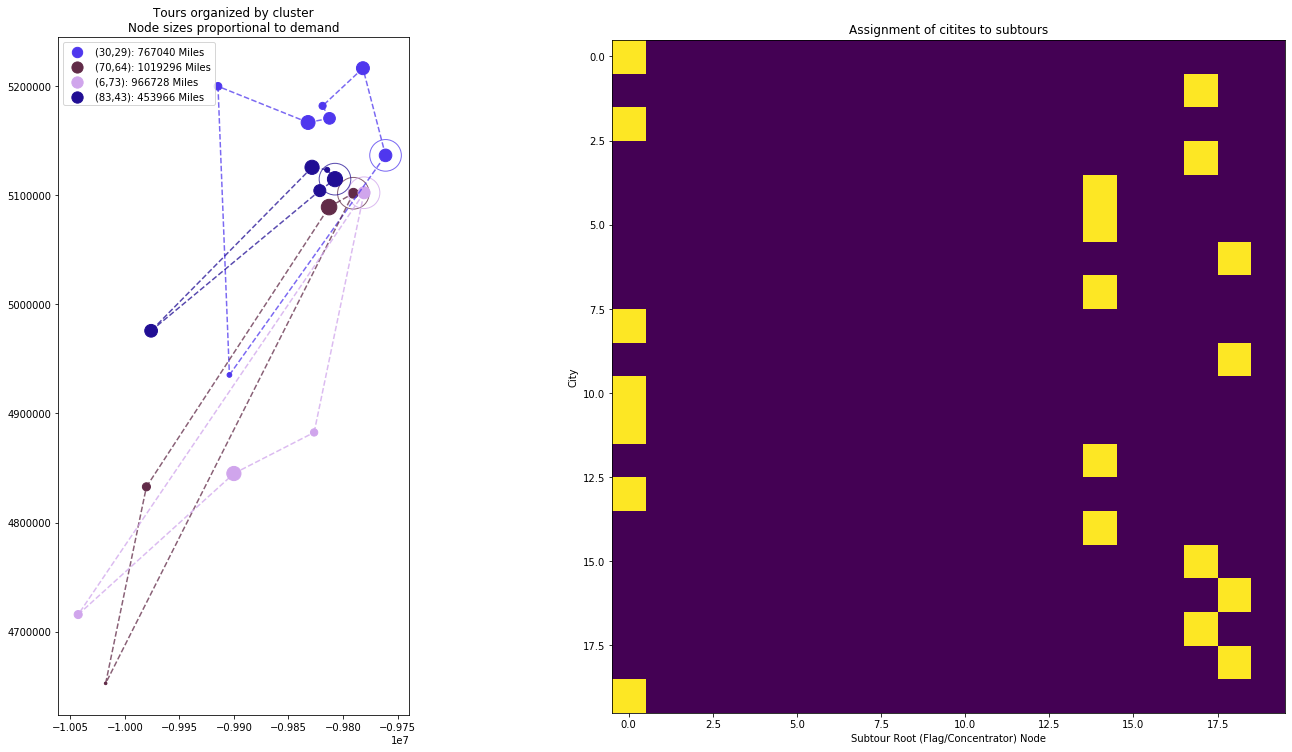

In [81]:
assignments = np.zeros((len(cities),len(cities)))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(len(cities)):
    for rootNodeID in range(len(cities)):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()
colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    label = f"({cities.iloc[uniqueClusters[i]].x},{cities.iloc[uniqueClusters[i]].y}): {tourLength} Miles"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
    # plot the tour
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls="dashed",alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")

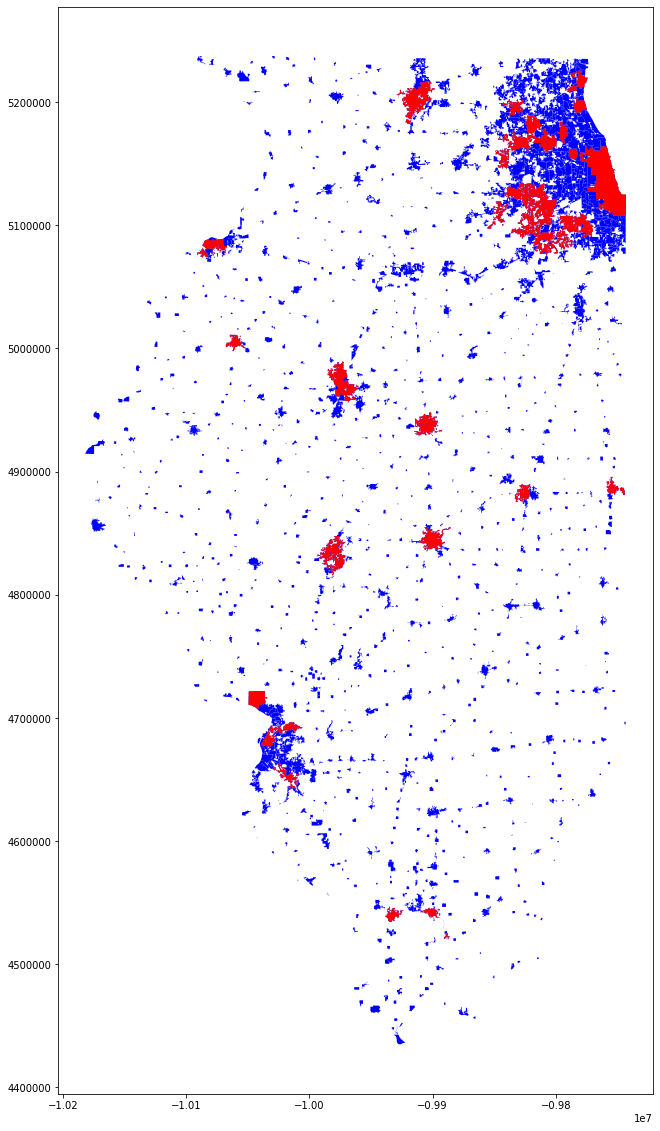

In [3]:
fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].plot(ax=ax,color="red")

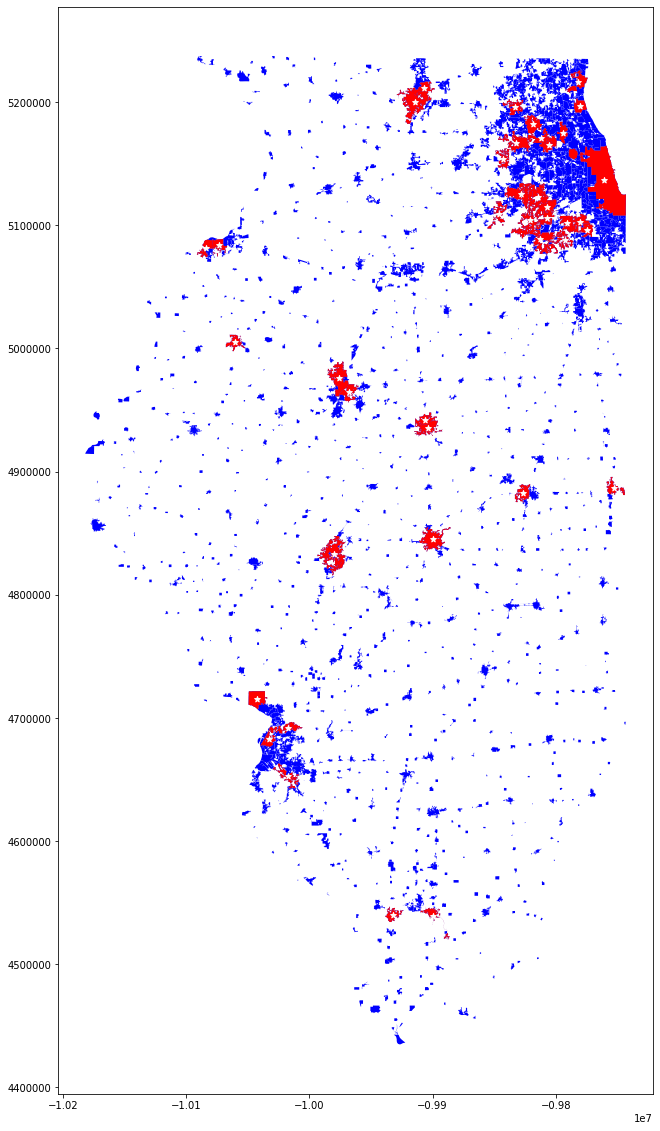

In [6]:
fig,ax = plt.subplots(figsize=(20,20))
illinois.plot(ax=ax,color="blue")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].plot(ax=ax,color="red")
illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax,color="white",marker='*')

Route for vehicle 0:
 0 -> 13 -> 0
Route distance: 165.108 km

Route for vehicle 0:
 2 -> 32 -> 2
Route distance: 171.572 km

Route for vehicle 0:
 8 -> 19 -> 31 -> 34 -> 25 -> 8
Route distance: 128.171 km

Route for vehicle 0:
 29 -> 35 -> 33 -> 29
Route distance: 170.275 km

Route for vehicle 0:
 30 -> 36 -> 30
Route distance: 65.956 km

Route for vehicle 0:
 3 -> 6 -> 3
Route distance: 162.21 km

Route for vehicle 0:
 10 -> 21 -> 10
Route distance: 139.868 km

Route for vehicle 0:
 5 -> 7 -> 14 -> 12 -> 20 -> 5
Route distance: 92.246 km

Route for vehicle 0:
 1 -> 26 -> 17 -> 18 -> 38 -> 39 -> 1
Route distance: 93.767 km

Route for vehicle 0:
 9 -> 22 -> 15 -> 24 -> 9
Route distance: 142.248 km

Route for vehicle 0:
 11 -> 23 -> 37 -> 11
Route distance: 188.879 km

Route for vehicle 0:
 4 -> 27 -> 4
Route distance: 155.164 km

Route for vehicle 0:
 16 -> 28 -> 16
Route distance: 147.526 km



Text(721.4, 0.5, 'City')

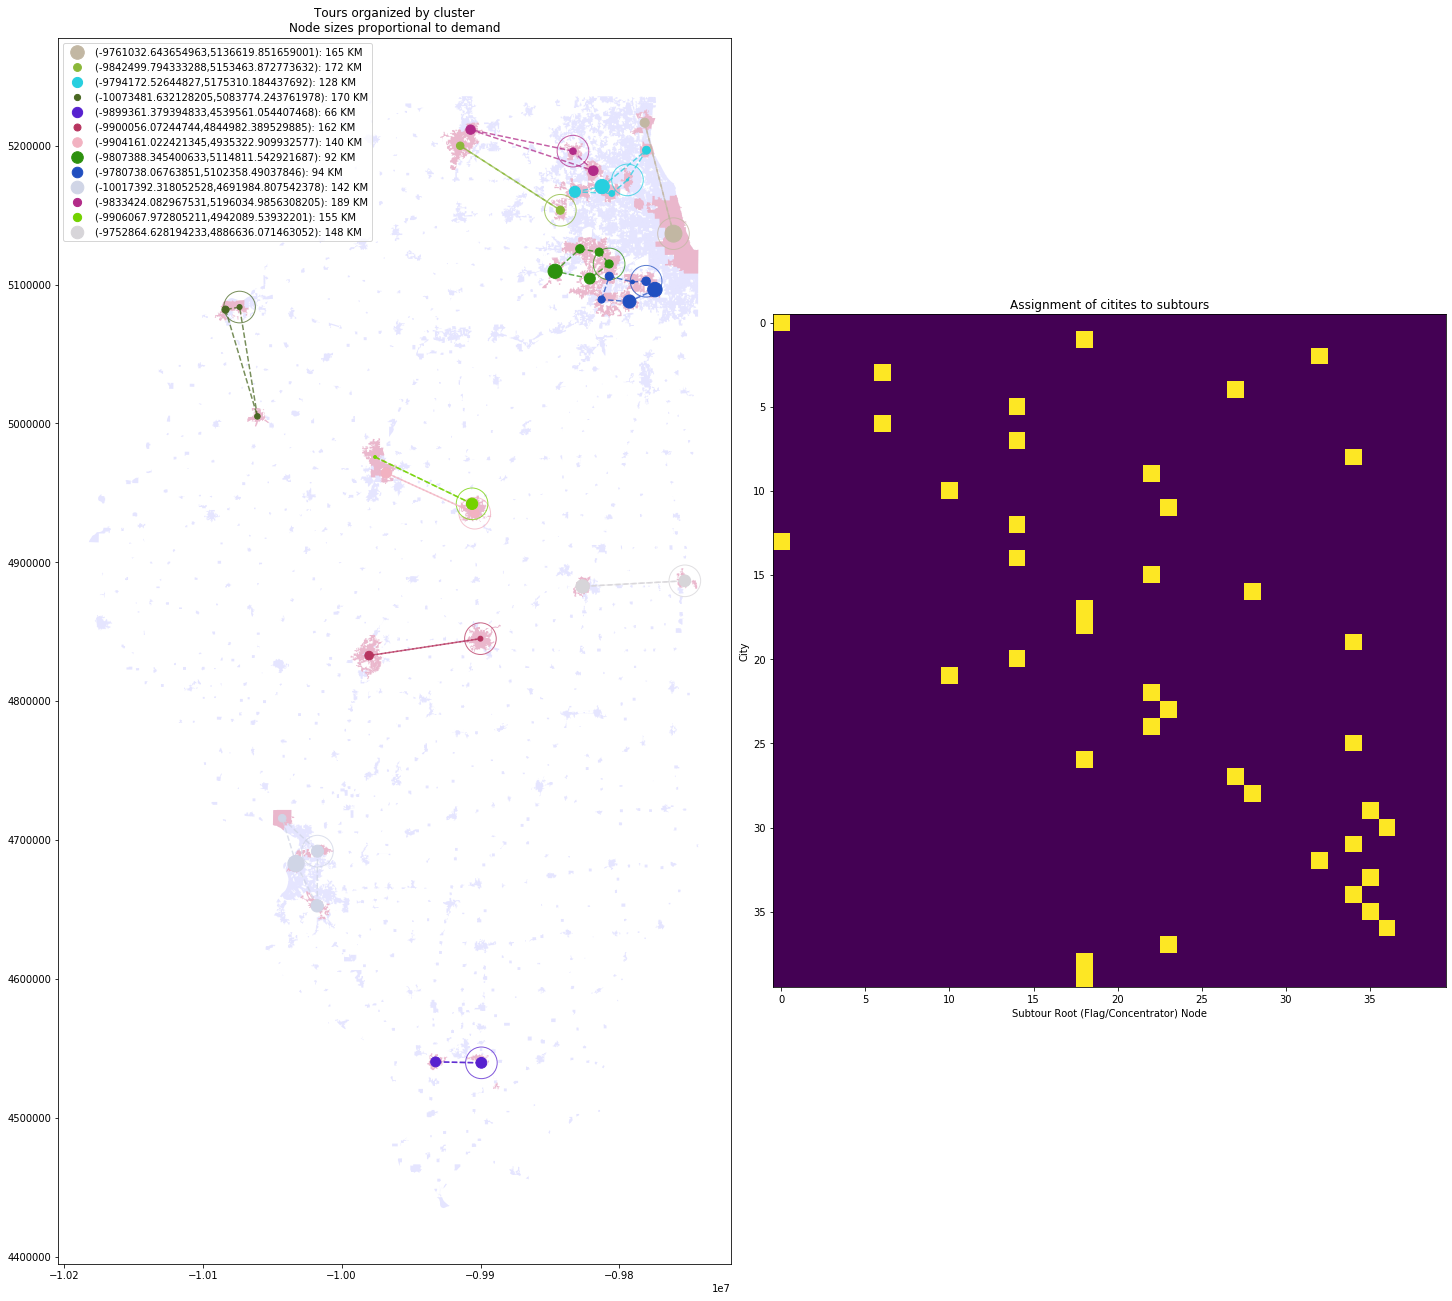

In [129]:
assignments = np.zeros((nCities,nCities))
for k,v in xij.items():
    i = k[0]
    j = k[1]
    assignments[i,j] = v.solution_value()
cluster = []
for cityNodeID in range(nCities):
    for rootNodeID in range(nCities):
        lookup = assignments[cityNodeID,rootNodeID]
        if lookup == 1:
            cluster.append(rootNodeID)
resultGDF["assignment"] = cluster
uniqueClusters = list(set(cluster))


fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.tight_layout()

illinois.plot(ax=ax1,color="blue",alpha=0.1)
illinois.sort_values("ALAND",ascending=False).reset_index()[0:nCities].plot(ax=ax1,color="red",alpha=0.2)
# illinois.sort_values("ALAND",ascending=False).reset_index()[0:40].centroid.plot(ax=ax1,color="white",marker='*')

colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(uniqueClusters))]
for i in range(0,len(uniqueClusters)):
    dfSubset = resultGDF[resultGDF["assignment"]==uniqueClusters[i]]
    tour,tourLength = main(dfSubset)
    label = f"({resultGDF.iloc[uniqueClusters[i]].x:,.0f},{resultGDF.iloc[uniqueClusters[i]].y:,.0f}): {tourLength/1000:,.0f} KM"
    # plot the nodes
    dfSubset.plot(ax=ax1,color=colors[i],markersize=dfSubset["demand"]/100,label=label)
    # plot the tour
    convertTourToPathDF(tour,resultGDF).plot(ax=ax1,colors=colors[i],ls="dashed",alpha=0.75)
    # plot the facilities
    dfFacility = resultGDF[resultGDF["City Index"]==uniqueClusters[i]]
    dfFacility.plot(ax=ax1,markersize=1000,marker="o",alpha=.75,facecolors='none', edgecolors=colors[i])
ax1.set_title("Tours organized by cluster\nNode sizes proportional to demand")
ax1.legend()
# Plot assignments
plt.imshow(assignments)
ax2.set_title("Assignment of citites to subtours")
ax2.set_xlabel("Subtour Root (Flag/Concentrator) Node")
ax2.set_ylabel("City")